# introduction
Le filtrage collaboratif est la technique la plus courante lorsqu'il s'agit de systèmes de recommandation. Comme son nom l'indique, il s'agit d'une technique qui permet de filtrer les éléments pour un utilisateur de manière collaborative, c'est-à-dire en fonction des préférences d'utilisateurs similaires.

>Soit une matrice d'évaluation utilisateur-élément M ci-dessous, où 6 utilisateurs (lignes) ont évalué 6 éléments (colonnes). Les évaluations peuvent prendre des valeurs entières de 1 à 10 et 0 indique l'absence d'évaluation. (Notez que nous utilisons l'indexation par zéro pour les lignes et les colonnes, comme en Python. Cependant, pour l'entrée utilisateur, user_id prendra des nombres de 1 à 6 et item_id de 1 à 6). Supposons que nous devions déterminer si l'utilisateur 3 aimera ou non l'article 4. Par conséquent, l'utilisateur 3 devient notre utilisateur cible ou utilisateur actif et l'élément 4 est l'élément cible.






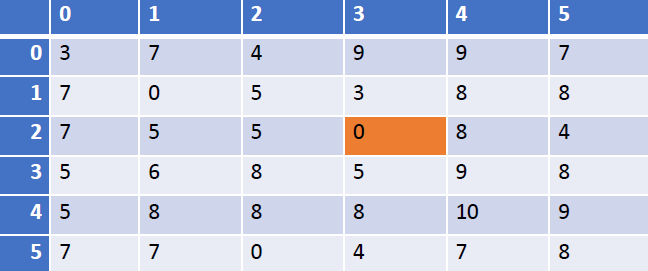

In [ ]:
from IPython.display import Image
Image(filename='/content/sample_data/11.png') 

Say Lizzy vient de regarder " Arrival " et " Blade Runner 2049 ", et veut maintenant qu'on lui recommande des films similaires, car elle les a aimés.


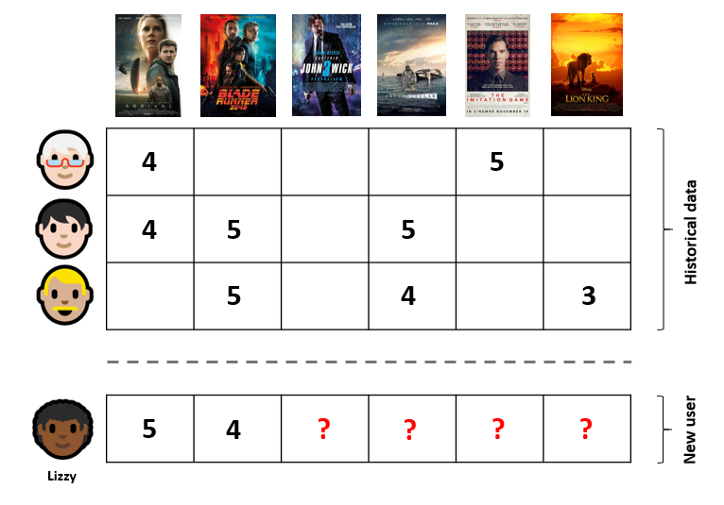

In [2]:
from IPython.display import Image
Image(filename='/content/sample_data/14.png') 

L'idée principale des méthodes de filtrage collaboratif est de trouver des utilisateurs qui ont également aimé ces films et de recommander des films invisibles en fonction de leurs préférences. Dans cet exemple, le modèle trouverait probablement que d'autres utilisateurs qui ont apprécié ces films ont également aimé « Interstellar », ce qui serait probablement une bonne recommandation pour Lizzy.

# Filtrage collaboratif basé sur l'utilisateur
Tout d'abord, nous devons prédire la note que l'utilisateur 3 donnera à l'élément 4. Dans le CF basé sur l'utilisateur, nous trouverons disons k=3 utilisateurs qui sont les plus similaires à l'utilisateur 3. Les mesures de similarité couramment utilisées sont le cosinus, Pearson, Euclidien, etc. Nous utiliserons ici la similarité cosinus qui est définie comme suit :

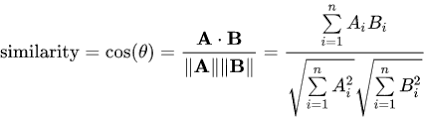

In [ ]:
from IPython.display import Image
Image(filename='/content/sample_data/12.png') 

> La similarité cosinus calcule le cosinus de l'angle entre deux vecteurs. Afin de calculer la similitude cosinus, nous utilisons la formule suivante:

Et, la corrélation pearson, définie comme :

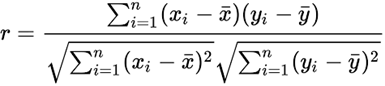

In [ ]:
from IPython.display import Image
Image(filename='/content/sample_data/13.png') 

> La corrélation est une technique permettant d'étudier la relation entre deux variables quantitatives continues, par exemple l'âge et la tension artérielle. Le coefficient de corrélation de Pearson est une mesure liée à la force et à la direction d'une relation linéaire. Nous calculons cette métrique pour les vecteurs x et y de la manière suivante:

Dans sklearn, la méthode NearestNeighbors peut être utilisée pour rechercher les k voisins les plus proches en fonction de diverses métriques de similarité.

ous travaillerons avec 2 fichiers: u.user , u.items

In [ ]:
! pip install pyspark

     |████████████████████████████████| 281.3 MB 31 kB/s 
     |████████████████████████████████| 198 kB 48.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=85fb7a009ae670050edbf539ec24ebda27dd4334950f83bcf38595485921128b
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

In [ ]:
from pyspark import SparkContext
sc=SparkContext()

In [ ]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('abc').getOrCreate()

# Phase exploratoire du Datasets
Nous allons afficher le contenue des jeux de données pour qu'on puisse à la fin tirer une similirater entre users /movies

In [ ]:
lines = sc.textFile("/content/sample_data/u.data")
parts = lines.map(lambda row: row.split("\t"))
print(parts.first())
ratingsRDD = parts.map(lambda p: Row(userId=int(p[0]), movieId=int(p[1]),rating=float(p[2]), timestamp=int(p[3])))
print(ratingsRDD.first())
ratings = spark.createDataFrame(ratingsRDD)

['196', '242', '3', '881250949']
Row(userId=196, movieId=242, rating=3.0, timestamp=881250949)


In [ ]:
lines = sc.textFile("/content/sample_data/u.user")
parts1 = lines.map(lambda row: row.split("|"))
print(parts1.first())
userRDD=parts1.map(lambda p: Row(userId=int(p[0]), age=p[1],genre=p[2], proffession=p[3]))
print(userRDD.first())
ratings1 = spark.createDataFrame(userRDD)

['1', '24', 'M', 'technician', '85711']
Row(userId=1, age='24', genre='M', proffession='technician')


In [ ]:
join=ratings1.join(ratings,on="userID")
join.show()

+------+---+-----+-----------+-------+------+---------+
|userId|age|genre|proffession|movieId|rating|timestamp|
+------+---+-----+-----------+-------+------+---------+
|    26| 49|    M|   engineer|    258|   3.0|891347949|
|    26| 49|    M|   engineer|    930|   2.0|891385985|
|    26| 49|    M|   engineer|   1015|   3.0|891352136|
|    29| 41|    M| programmer|    245|   3.0|882820803|
|    26| 49|    M|   engineer|    125|   4.0|891371676|
|    29| 41|    M| programmer|    189|   4.0|882821942|
|    26| 49|    M|   engineer|    685|   3.0|891371676|
|    26| 49|    M|   engineer|    235|   2.0|891372429|
|    29| 41|    M| programmer|    332|   4.0|882820869|
|    29| 41|    M| programmer|    539|   2.0|882821044|
|    26| 49|    M|   engineer|     25|   3.0|891373727|
|    26| 49|    M|   engineer|    455|   3.0|891371506|
|    26| 49|    M|   engineer|   1016|   3.0|891377609|
|    26| 49|    M|   engineer|     15|   4.0|891386369|
|    26| 49|    M|   engineer|    257|   3.0|891

In [ ]:
lines = sc.textFile("/content/sample_data/u.item")
parts1 = lines.map(lambda row: row.split("|"))
print(parts1.first())

['1', 'Toy Story (1995)', '01-Jan-1995', '', 'http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


In [ ]:
lines = sc.textFile("/content/sample_data/u.item")
parts2 = lines.map(lambda row: row.split("|"))
print(parts2.first())
MVRDD=parts2.map(lambda p: Row(movieId=int(p[0]), titre=p[1], unknown=p[6], Action=p[7], Adventure=p[8], Children=p[9], Comedy=p[10], Crime=p[11], Documentary=p[12], Drama=p[13], Fantasy=p[14]))
print(MVRDD.first())
MV = spark.createDataFrame(MVRDD)

['1', 'Toy Story (1995)', '01-Jan-1995', '', 'http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Row(movieId=1, titre='Toy Story (1995)', unknown='0', Action='0', Adventure='1', Children='1', Comedy='1', Crime='0', Documentary='0', Drama='0', Fantasy='0')


In [ ]:
join2=MV.join(join,on="movieId")
join2.show()

+-------+--------------------+-------+------+---------+--------+------+-----+-----------+-----+-------+------+---+-----+-----------+------+---------+
|movieId|               titre|unknown|Action|Adventure|Children|Comedy|Crime|Documentary|Drama|Fantasy|userId|age|genre|proffession|rating|timestamp|
+-------+--------------------+-------+------+---------+--------+------+-----+-----------+-----+-------+------+---+-----+-----------+------+---------+
|    258|      Contact (1997)|      0|     0|        0|       0|     0|    0|          0|    1|      0|    26| 49|    M|   engineer|   3.0|891347949|
|    930|Chain Reaction (1...|      1|     1|        0|       0|     0|    0|          0|    0|      0|    26| 49|    M|   engineer|   2.0|891385985|
|   1015|       Shiloh (1997)|      0|     0|        0|       1|     0|    0|          0|    1|      0|    26| 49|    M|   engineer|   3.0|891352136|
|    245|Devil's Own, The ...|      1|     0|        0|       0|     0|    0|          0|    1|     

In [ ]:
l = sc.textFile("/content/sample_data/u.data")
pa = l.map(lambda row: row.split("\t"))
print(pa.first())
uRDD = pa.map(lambda p: Row(userId=int(p[0]), movieId=int(p[1]),rating=float(p[2])))
print(uRDD.first())
u = spark.createDataFrame(uRDD)

['196', '242', '3', '881250949']
Row(userId=196, movieId=242, rating=3.0)


In [ ]:
u.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|   196|    242|   3.0|
|   186|    302|   3.0|
|    22|    377|   1.0|
|   244|     51|   2.0|
|   166|    346|   1.0|
|   298|    474|   4.0|
|   115|    265|   2.0|
|   253|    465|   5.0|
|   305|    451|   3.0|
|     6|     86|   3.0|
|    62|    257|   2.0|
|   286|   1014|   5.0|
|   200|    222|   5.0|
|   210|     40|   3.0|
|   224|     29|   3.0|
|   303|    785|   3.0|
|   122|    387|   5.0|
|   194|    274|   2.0|
|   291|   1042|   4.0|
|   234|   1184|   2.0|
+------+-------+------+
only showing top 20 rows



In [ ]:

pandasDF = u.toPandas()
print(pandasDF)

       userId  movieId  rating
0         196      242     3.0
1         186      302     3.0
2          22      377     1.0
3         244       51     2.0
4         166      346     1.0
...       ...      ...     ...
99995     880      476     3.0
99996     716      204     5.0
99997     276     1090     1.0
99998      13      225     2.0
99999      12      203     3.0

[100000 rows x 3 columns]


# Matrice des éléments utilisateur
La première chose à faire est de créer la matrice d'éléments utilisateur. Il s'agit essentiellement d'un tableau croisé dynamique à partir des données de notation, où les lignes seront les utilisateurs, les colonnes seront les films et le dataframe est rempli avec la note que l'utilisateur a donnée (si elle existe, 0sinon):

-----------------------------------------------

In [ ]:

movies_pivot = join2.groupBy('titre').pivot('userId').sum('rating').fillna(0)
movies_pivot.show()

+--------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+--

# Matrice de similarité
Ensuite, nous définirons une matrice de similarité.  nous voulons trouver une mesure de proximité entre tous les  utilisateurs (ou éléments) dans la matrice d'éléments utilisateur . Une mesure couramment utilisée est la similitude cosinus .

 cette mesure de similarité doit son nom au fait qu'elle est égale au cosinus de l'angle entre les deux vecteurs comparés, vecteurs de similarité utilisateur (ou item) des scores dans ce cas. Plus l'angle entre deux vecteurs est bas, plus le cosinus sera élevé, d'où un facteur de similitude plus élevé. Consultez la section ci-dessus pour plus de détails à ce sujet.

In [ ]:

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [ ]:
movie_features_df = movies_pivot.toPandas().set_index('titre')
movie_features_df_matrix = csr_matrix(movie_features_df.values)

Dans sklearn, la méthode NearestNeighbors peut être utilisée pour rechercher les k voisins les plus proches sur la base de diverses métriques de similarité.

Différentes façons de calculer la distance
* Distance de Minkowski (Euclidienne, Manhattan, etc.)
* Distance de Chebyshev
* Similitude en cosinus
* Distance de Hamming
> Nous allons utiliser dans cette partie la similitude de cosinus

 Plus l'angle est petit, plus la similarité en cosinus est élevée.




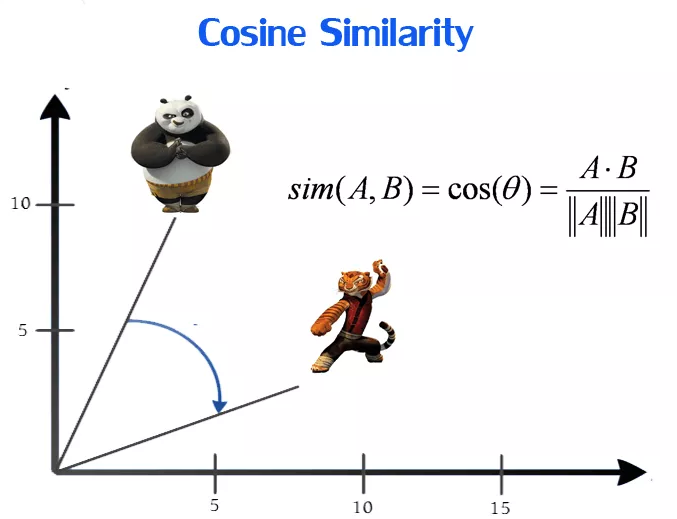

In [1]:
from IPython.display import Image
Image(filename='/content/sample_data/téléchargement.png') 

In [ ]:
"""fitting the final unsupervised model NearestNeighbors to find the most similar movies of each ones using the whole dataset"""
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=11, n_jobs=-1)
model_knn.fit(movie_features_df_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=11)

In [ ]:
# choosing a title from our movie matrix
favoriteMovie = 'Blue Chips (1994)'
query_index = movie_features_df.index.get_loc(favoriteMovie)
distances, indices = model_knn.kneighbors(movie_features_df.loc[favoriteMovie,:].values.reshape(1, -1), n_neighbors=11)

Le modele va chercher un cluster qui contient top 10 films similere a Blue chips(1994) en se basant sur les films deja vu et notés

In [ ]:
# printing the 10 most similar movies according to the kNN model
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(movie_features_df.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, movie_features_df.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Blue Chips (1994):

1: Fear, The (1995), with distance of 0.5149287499273341:
2: New Jersey Drive (1995), with distance of 0.5661390843626877:
3: Panther (1995), with distance of 0.5755626561864173:
4: Hideaway (1995), with distance of 0.6058796093159589:
5: Waiting to Exhale (1995), with distance of 0.6297341844113227:
6: Higher Learning (1995), with distance of 0.6676577068574308:
7: Free Willy (1993), with distance of 0.6862334918930192:
8: Tie That Binds, The (1995), with distance of 0.6943439751349041:
9: Clockers (1995), with distance of 0.7031090502851554:
10: Dumb & Dumber (1994), with distance of 0.7068500991432798:


------------------------

# Methode2

In [ ]:
global k,metric
k=4
metric='cosine'

In [ ]:
user_item_ = pandasDF.pivot('userId','movieId','rating').fillna(0)#pivoter la matrice pour 
#qu'on puisse avoir L=users C=items case=ratings
print(f'Shape: {user_item_.shape}')

Shape: (943, 1682)


In [ ]:
user_item_.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662,1663,1664,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,2.0,5.0,5.0,5.0,5.0,5.0,3.0,4.0,5.0,4.0,1.0,4.0,4.0,3.0,4.0,3.0,2.0,4.0,1.0,3.0,3.0,5.0,4.0,2.0,1.0,2.0,2.0,3.0,4.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#make necesarry imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation, cosine
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt
import sys, os
from contextlib import contextmanager

In [ ]:
#Nous pouvons utiliser un sklearn's metrics.pairwisesous-module pour les mesures de distance ou de similarité par paires, dans ce cas, 
#nous utiliserons cosine_similarity.
cosine_sim = 1-pairwise_distances(user_item_, metric="cosine")#nous avons utiliser metric de cosine


In [ ]:
#Cosine similarity matrix
pd.DataFrame(cosine_sim)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942
0,1.000000,0.166931,0.047460,0.064358,0.378475,0.430239,0.440367,0.319072,0.078138,0.376544,0.311124,0.314678,0.439743,0.332107,0.181473,0.403987,0.215819,0.473875,0.109084,0.241498,0.198413,0.381042,0.446288,0.285399,0.335553,0.252066,0.129579,0.302737,0.129084,0.181933,0.114717,0.209719,0.032820,0.029046,0.036318,0.026590,0.278971,0.195617,0.057517,0.083809,...,0.112985,0.122914,0.138209,0.234845,0.276285,0.116184,0.260551,0.285488,0.204004,0.437751,0.057587,0.047805,0.569066,0.140963,0.232308,0.338279,0.058859,0.276885,0.383251,0.158199,0.302857,0.079341,0.083955,0.257381,0.234315,0.280072,0.279170,0.146437,0.354255,0.490353,0.369527,0.119482,0.274876,0.189705,0.197326,0.118095,0.314072,0.148617,0.179508,0.398175
1,0.166931,1.000000,0.110591,0.178121,0.072979,0.245843,0.107328,0.103344,0.161048,0.159862,0.129257,0.121268,0.223661,0.226758,0.455361,0.125330,0.223667,0.179218,0.101374,0.060499,0.204445,0.064443,0.146500,0.178323,0.148638,0.445594,0.185077,0.102455,0.175115,0.230078,0.081875,0.216032,0.167204,0.212489,0.075602,0.107012,0.079821,0.058597,0.268489,0.251593,...,0.211427,0.224852,0.278382,0.269172,0.101681,0.153909,0.345035,0.025506,0.023080,0.170131,0.039270,0.260726,0.116597,0.284455,0.049835,0.376975,0.328677,0.167278,0.122291,0.231709,0.244595,0.048471,0.390525,0.113863,0.091148,0.114631,0.288602,0.512473,0.047879,0.102243,0.156986,0.307942,0.358789,0.424046,0.319889,0.228583,0.226790,0.161485,0.172268,0.105798
2,0.047460,0.110591,1.000000,0.344151,0.021245,0.072415,0.066137,0.083060,0.061040,0.065151,0.075912,0.067345,0.198196,0.042780,0.129912,0.058530,0.031320,0.033788,0.104290,0.050696,0.165823,0.034462,0.030955,0.071430,0.037031,0.163477,0.021322,0.068035,0.153260,0.108480,0.190257,0.125907,0.386958,0.140309,0.247316,0.132368,0.012527,0.062250,0.284856,0.385311,...,0.064352,0.220405,0.063105,0.136337,0.083157,0.071430,0.048256,0.009207,0.034366,0.088333,0.000000,0.358316,0.046124,0.044585,0.006246,0.264406,0.434379,0.094758,0.055179,0.164234,0.069298,0.184687,0.286220,0.052784,0.070027,0.036707,0.023085,0.176416,0.000000,0.036302,0.031875,0.042753,0.163829,0.069038,0.124245,0.026271,0.161890,0.101243,0.133416,0.026556
3,0.064358,0.178121,0.344151,1.000000,0.031804,0.068044,0.091230,0.188060,0.101284,0.060859,0.104182,0.075324,0.120306,0.070670,0.148397,0.084951,0.053895,0.035582,0.158678,0.086565,0.189713,0.082280,0.061922,0.175470,0.084112,0.151322,0.074295,0.151293,0.143465,0.144516,0.070563,0.132090,0.339211,0.152106,0.196643,0.067042,0.111555,0.065307,0.228181,0.238689,...,0.073434,0.171210,0.027923,0.115243,0.106580,0.081942,0.151247,0.029705,0.032256,0.107485,0.000000,0.136295,0.055061,0.043939,0.000000,0.182571,0.171236,0.100374,0.132542,0.094344,0.082147,0.168100,0.232185,0.127523,0.053364,0.048234,0.073335,0.138921,0.023274,0.071446,0.052107,0.036784,0.133115,0.193471,0.146058,0.030138,0.196858,0.152041,0.170086,0.058752
4,0.378475,0.072979,0.021245,0.031804,1.000000,0.237286,0.373600,0.248930,0.056847,0.201427,0.321710,0.130664,0.345217,0.244741,0.096349,0.287556,0.084729,0.289495,0.116843,0.240738,0.176494,0.455057,0.409268,0.137635,0.329765,0.152247,0.080846,0.322380,0.052199,0.164811,0.041286,0.165350,0.000000,0.002489,0.009077,0.000000,0.243336,0.254872,0.000000,0.005292,...,0.048666,0.022342,0.062368,0.145534,0.231190,0.026398,0.191689,0.350941,0.175405,0.334656,0.038711,0.000000,0.342110,0.074416,0.168863,0.185523,0.000000,0.258688,0.423096,0.159031,0.211030,0.063369,0.000000,0.289893,0.085181,0.233524,0.143641,0.068424,0.324288,0.373698,0.338794,0.080580,0.094924,0.079779,0.148607,0.071459,0.239955,0.139595,0.152497,0.313941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
#get pearson similarities for ratings matrix user_item_
pearson_sim = 1-pairwise_distances(user_item_, metric="correlation")#nous avons utiliser metric de correlation

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
X_user = cosine_similarity(user_item_)
X_user[:10,:8].round(3)

array([[1.   , 0.167, 0.047, 0.064, 0.378, 0.43 , 0.44 , 0.319],
       [0.167, 1.   , 0.111, 0.178, 0.073, 0.246, 0.107, 0.103],
       [0.047, 0.111, 1.   , 0.344, 0.021, 0.072, 0.066, 0.083],
       [0.064, 0.178, 0.344, 1.   , 0.032, 0.068, 0.091, 0.188],
       [0.378, 0.073, 0.021, 0.032, 1.   , 0.237, 0.374, 0.249],
       [0.43 , 0.246, 0.072, 0.068, 0.237, 1.   , 0.489, 0.201],
       [0.44 , 0.107, 0.066, 0.091, 0.374, 0.489, 1.   , 0.285],
       [0.319, 0.103, 0.083, 0.188, 0.249, 0.201, 0.285, 1.   ],
       [0.078, 0.161, 0.061, 0.101, 0.057, 0.184, 0.146, 0.086],
       [0.377, 0.16 , 0.065, 0.061, 0.201, 0.552, 0.487, 0.233]])

In [ ]:
#Pearson correlation similarity matrix
pd.DataFrame(pearson_sim)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942
0,1.000000,0.106322,-0.016424,0.021716,0.302592,0.345976,0.320017,0.276208,0.038812,0.288491,0.217507,0.273815,0.296534,0.270445,0.106351,0.335007,0.184958,0.380732,0.074695,0.198485,0.098842,0.318704,0.379766,0.231979,0.281809,0.178358,0.092360,0.246582,0.083585,0.134798,0.066344,0.166742,-0.013125,-0.011084,-0.008550,-0.013843,0.232300,0.113773,0.016628,0.034688,...,0.056125,0.072093,0.087437,0.139975,0.218879,0.075943,0.211707,0.218533,0.152117,0.377348,0.017865,0.002821,0.487949,0.097007,0.159046,0.238376,0.014200,0.206190,0.317505,0.088004,0.244603,0.031617,0.047844,0.179413,0.199129,0.238361,0.231222,0.083730,0.249563,0.426137,0.285923,0.068878,0.189272,0.146979,0.119444,0.060175,0.247483,0.115504,0.108984,0.323231
1,0.106322,1.000000,0.082680,0.160323,0.020218,0.197844,0.022886,0.072772,0.143716,0.106861,0.075766,0.092465,0.147474,0.191993,0.432019,0.077818,0.206313,0.117309,0.083600,0.032104,0.159973,0.018688,0.098722,0.147140,0.113763,0.420319,0.167306,0.066191,0.153623,0.207484,0.057122,0.193653,0.148923,0.197814,0.055391,0.089865,0.048516,0.013603,0.253834,0.232400,...,0.186997,0.202837,0.257415,0.228831,0.066123,0.134579,0.322636,-0.018693,-0.009086,0.127481,0.019657,0.244619,0.043629,0.266140,0.006593,0.339394,0.314020,0.128491,0.077631,0.201167,0.213287,0.024560,0.379684,0.070114,0.067676,0.086790,0.263913,0.495166,-0.022052,0.049557,0.106416,0.288550,0.325233,0.408466,0.289112,0.204094,0.190848,0.144177,0.138292,0.054235
2,-0.016424,0.082680,1.000000,0.331674,-0.028322,0.017673,-0.013384,0.055385,0.043505,0.012080,0.025442,0.040268,0.129876,0.004462,0.096585,0.013078,0.011647,-0.034706,0.088497,0.025274,0.124820,-0.007348,-0.017713,0.040256,0.002089,0.129180,0.001982,0.034740,0.133598,0.085206,0.170915,0.103694,0.375219,0.125681,0.232909,0.117553,-0.017218,0.022689,0.271927,0.371283,...,0.038628,0.200695,0.038838,0.093545,0.051080,0.052404,0.019433,-0.030587,0.006215,0.046744,-0.018186,0.345865,-0.025589,0.022542,-0.033843,0.224201,0.423346,0.057450,0.012516,0.134918,0.035108,0.166592,0.274150,0.011324,0.048688,0.009863,-0.006934,0.150569,-0.065909,-0.014137,-0.020605,0.018746,0.124174,0.046247,0.088974,-0.001145,0.127539,0.084532,0.102025,-0.023601
3,0.021716,0.160323,0.331674,1.000000,-0.002426,0.030206,0.041056,0.171116,0.089372,0.024018,0.071262,0.056481,0.066668,0.044836,0.126110,0.054693,0.040303,-0.011837,0.148089,0.069366,0.163750,0.054926,0.029479,0.156495,0.061020,0.127635,0.061360,0.130522,0.129412,0.128847,0.054866,0.116582,0.329946,0.141741,0.185558,0.055604,0.092868,0.037886,0.218010,0.226335,...,0.055522,0.156490,0.010156,0.085330,0.084895,0.068612,0.133391,0.002384,0.012381,0.079686,-0.012844,0.124093,0.006625,0.028358,-0.028503,0.152497,0.159370,0.074810,0.106218,0.072190,0.058690,0.155011,0.222635,0.101712,0.038013,0.029559,0.053381,0.120145,-0.021349,0.038206,0.016641,0.019738,0.105135,0.179598,0.122649,0.010890,0.174904,0.140811,0.149575,0.025367
4,0.302592,0.020218,-0.028322,-0.002426,1.000000,0.153409,0.279677,0.209280,0.025496,0.117166,0.252772,0.085580,0.229683,0.189778,0.032820,0.224095,0.052050,0.198013,0.090244,0.205944,0.099764,0.412184,0.354731,0.085329,0.286415,0.087925,0.048942,0.279251,0.012533,0.126665,-0.000172,0.128379,-0.036292,-0.029068,-0.026161,-0.031751,0.203441,0.197375,-0.034123,-0.036586,...,0.001306,-0.022650,0.018626,0.065885,0.182872,-0.009780,0.148305,0.303923,0.132861,0.278610,0.007465,-0.036568,0.253080,0.036331,0.107855,0.094282,-0.037063,0.202748,0.375348,0.105465,0.158590,0.026047,-0.032250,0.232972,0.047889,0.196578,0.096518,0.015334,0.244056,0.313342,0.272866,0.039333,0.013999,0.039519,0.085548,0.024292,0.182466,0.112571,0.096603,0.248991
...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
global k,metric
k=4
metric='cosine'

# La similarité en se basant sur les users

In [ ]:
#This function finds k similar users given the user_id and ratings matrix user_item_
#Note that the similarities are same as obtained via using pairwise_distances
def findksimilarusers(user_id, ratings, metric = metric, k=k):
    similarities=[]
    indices=[]
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute') 
    model_knn.fit(ratings)

    distances, indices = model_knn.kneighbors(ratings.iloc[user_id-1, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()
    print ('{0} most similar users for User {1}:\n'.format(k,user_id))
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i]+1 == user_id:
            continue;

        else:
            print ('{0}: User {1}, with similarity of {2}'.format(i, indices.flatten()[i]+1, similarities.flatten()[i]))
            
    return similarities,indices

In [ ]:
similarities,indices = findksimilarusers(1,user_item_, metric='cosine')

4 most similar users for User 1:

1: User 916, with similarity of 0.5690657315279879
2: User 864, with similarity of 0.5475482621940833
3: User 268, with similarity of 0.5420770475201058
4: User 92, with similarity of 0.5405335611842339


In [ ]:
similarities,indices = findksimilarusers(1,user_item_, metric='correlation')

4 most similar users for User 1:

1: User 916, with similarity of 0.48794913303276355
2: User 738, with similarity of 0.47110484000734654
3: User 864, with similarity of 0.46528274857184826
4: User 457, with similarity of 0.45711131219816603


In [ ]:
#This function predicts rating for specified user-item combination based on user-based approach
def predict_userbased(user_id, item_id, ratings, metric = metric, k=k):
    prediction=0
    similarities, indices=findksimilarusers(user_id, ratings,metric, k) #similar users based on cosine similarity
    mean_rating = ratings.loc[user_id-1,:].mean() #to adjust for zero based indexing
    sum_wt = np.sum(similarities)-1
    product=1
    wtd_sum = 0 
    
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i]+1 == user_id:
            continue;
        else: 
            ratings_diff = ratings.iloc[indices.flatten()[i],item_id-1]-np.mean(ratings.iloc[indices.flatten()[i],:])
            product = ratings_diff * (similarities[i])
            wtd_sum = wtd_sum + product
    
    prediction = int(round(mean_rating + (wtd_sum/sum_wt)))
    print ('\nPredicted rating for user {0} -> item {1}: {2}'.format(user_id,item_id,prediction))

    return prediction

In [ ]:
predict_userbased(3,4,user_item_);

4 most similar users for User 3:

1: User 863, with similarity of 0.48903179427148014
2: User 489, with similarity of 0.485924526259488
3: User 616, with similarity of 0.48292093431167515
4: User 587, with similarity of 0.46883418939072585

Predicted rating for user 3 -> item 4: 0


# La similarité en se basant sur les items

In [ ]:
#This function finds k similar items given the item_id and ratings matrix user_item_

def findksimilaritems(item_id, ratings, metric=metric, k=k):
    similarities=[]
    indices=[]    
    ratings=ratings.T
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute')
    model_knn.fit(ratings)

    distances, indices = model_knn.kneighbors(ratings.iloc[item_id-1, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()
    print ('{0} most similar items for item {1}:\n'.format(k,item_id))
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i]+1 == item_id:
            continue;

        else:
            print ('{0}: Item {1} :, with similarity of {2}'.format(i,indices.flatten()[i]+1, similarities.flatten()[i]))


    return similarities,indices

In [ ]:
similarities,indices=findksimilaritems(3,user_item_)

4 most similar items for item 3:

1: Item 410 :, with similarity of 0.45202290913857934
2: Item 763 :, with similarity of 0.44435507440937694
3: Item 42 :, with similarity of 0.42324934635999734
4: Item 33 :, with similarity of 0.4049303159741996


In [ ]:
#This function predicts the rating for specified user-item combination based on item-based approach
def predict_itembased(user_id, item_id, ratings, metric = metric, k=k):
    prediction= wtd_sum =0
    similarities, indices=findksimilaritems(item_id, ratings) #similar users based on correlation coefficients
    sum_wt = np.sum(similarities)-1
    product=1
    
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i]+1 == item_id:
            continue;
        else:
            product = ratings.iloc[user_id-1,indices.flatten()[i]] * (similarities[i])
            wtd_sum = wtd_sum + product                              
    prediction = int(round(wtd_sum/sum_wt))
    print ('\nPredicted rating for user {0} -> item {1}: {2}'.format(user_id,item_id,prediction))     

    return prediction

In [ ]:
prediction = predict_itembased(1,3,user_item_)

4 most similar items for item 3:

1: Item 410 :, with similarity of 0.45202290913857934
2: Item 763 :, with similarity of 0.44435507440937694
3: Item 42 :, with similarity of 0.42324934635999734
4: Item 33 :, with similarity of 0.4049303159741996

Predicted rating for user 1 -> item 3: 2


In [ ]:
#make necesarry imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation, cosine
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt
import sys, os
from contextlib import contextmanager

In [ ]:
#This function utilizes above function to recommend items for selected approach. Recommendations are made if the predicted
#rating for an item is greater than or equal to 6, and the items has not been rated already
def recommendItem(user_id, item_id, ratings):
    
    if user_id<1 or user_id>6 or type(user_id) is not int:
        print ('Userid does not exist. Enter numbers from 1-6')
    else:    
        ids = ['User-based CF (cosine)','User-based CF (correlation)','Item-based CF (cosine)',
               'a']

        approach = widgets.Dropdown(options=ids, value=ids[0],
                               description='Select Approach', width='500px')
        
        def on_change(change):
            prediction = 0
            clear_output(wait=True)
            if change['type'] == 'change' and change['name'] == 'value':            
                if (approach.value == 'User-based CF (cosine)'):
                    metric = 'cosine'
                    prediction = predict_userbased(user_id, item_id, ratings, metric)
                elif (approach.value == 'User-based CF (correlation)')  :                       
                    metric = 'correlation'  
                    prediction = predict_userbased(user_id, item_id, ratings, metric)
                elif (approach.value == 'Item-based CF (cosine)'):
                    prediction = predict_itembased(user_id, item_id, ratings)
              

                if ratings[item_id-1][user_id-1] != 0: 
                    print ('Item already rated')
                else:
                    if prediction>=6:
                        print ('\nItem recommended')
                    else:
                        print ('Item not recommended')

        approach.observe(on_change)
        display(approach)             

In [ ]:
recommendItem(6,6,user_item_)

4 most similar users for User 6:

1: User 474, with similarity of 0.5298771692099694
2: User 18, with similarity of 0.5214016425621493
3: User 840, with similarity of 0.5004422969426873
4: User 271, with similarity of 0.4980972037912006

Predicted rating for user 6 -> item 6: 1
Item not recommended


In [ ]:
#This is a quick way to temporarily suppress stdout in particular code section
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

# Évaluation du système de recommandation
Il existe de nombreuses mesures d'évaluation des systèmes de recommandation. Cependant, la plus populaire et la plus utilisée est la RMSE (root mean squared error). La fonction evaluateRS utilise la fonction mean_squared_error de sklearn pour calculer la RMSE entre les évaluations prédites et les évaluations réelles, et affiche les valeurs RMSE pour l'approche sélectionnée

In [ ]:
#This is final function to evaluate the performance of selected recommendation approach and the metric used here is RMSE
#suppress_stdout function is used to suppress the print outputs of all the functions inside this function. It will only print 
#RMSE values
def evaluateRS(ratings):
    ids = ['User-based CF (cosine)','User-based CF (correlation)','Item-based CF (cosine)','a']
    approach = widgets.Dropdown(options=ids, value=ids[0],description='Select Approach', width='500px')
    n_users = ratings.shape[0]
    n_items = ratings.shape[1]
    prediction = np.zeros((n_users, n_items))
    prediction= pd.DataFrame(prediction)
    def on_change(change):
        clear_output(wait=True)
        with suppress_stdout():
            if change['type'] == 'change' and change['name'] == 'value':            
                if (approach.value == 'User-based CF (cosine)'):
                    metric = 'cosine'
                    for i in range(n_users):
                        for j in range(n_items):
                            prediction[i][j] = predict_userbased(i+1, j+1, ratings, metric)
                elif (approach.value == 'User-based CF (correlation)')  :                       
                    metric = 'correlation'               
                    for i in range(n_users):
                        for j in range(n_items):
                            prediction[i][j] = predict_userbased(i+1, j+1, ratings, metric)
                elif (approach.value == 'Item-based CF (cosine)'):
                    for i in range(n_users):
                        for j in range(n_items):
                            prediction[i][j] = predict_userbased(i+1, j+1, ratings)
                else:
                    for i in range(n_users):
                        for j in range(n_items):
                            prediction[i][j] = predict_userbased(i+1, j+1, ratings)
                         
              
        MSE = mean_squared_error(prediction, ratings)
        RMSE = round(sqrt(MSE),3)
        print ("RMSE using {0} approach is: {1}".format(approach.value,RMSE))
              
    approach.observe(on_change)
    display(approach)

In [ ]:
evaluateRS(user_item_)

RMSE using Item-based CF (cosine) approach is: 0.93


KeyError: ignored